<a href="https://colab.research.google.com/github/nselem/ccm-bioinfomatica-lab/blob/main/Hackaton_junio2023/Resistencia/codigos/Camda_clasificacion_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
os.chdir('/content/drive/My Drive/Cursos/metagenomica/camda2023/Notebooks/')
!pwd

/content/drive/My Drive/Cursos/metagenomica/camda2023/Notebooks


In [3]:
#import contextily as ctx
#import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

## $X$: Otus, $y$: city

In [7]:
carpeta_data = "data"
nombre_archivo = "relative_order_assembly.csv"

# Obtén la ruta absoluta de la carpeta actual
ruta_actual = os.getcwd()
# Construye la ruta completa al archivo CSV dentro de la carpeta "data"
ruta_archivo = os.path.join(ruta_actual, carpeta_data, nombre_archivo)
otus = pd.read_csv(ruta_archivo, index_col="ID")

cont_names = list(otus.drop(["ID_city","City","Climate","Latitude", "Longitude","Year"], axis=1).columns)
y_names = ["ID_city"]
otus_df = otus[cont_names+y_names]
otus_df.shape

(365, 288)

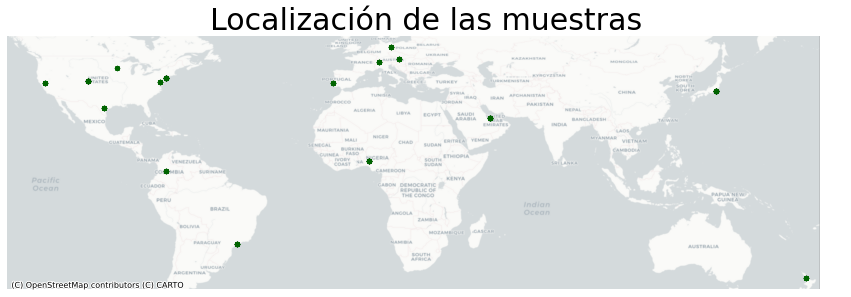

In [ ]:
otus_gdf = gpd.GeoDataFrame(otus.copy(), geometry=gpd.points_from_xy(otus['Longitude'], otus['Latitude']), crs='EPSG:4326')

fig, ax = plt.subplots(1, figsize=(15, 15))
otus_gdf.plot(marker='.', c='darkgreen', ax=ax, markersize=70, zorder=1)
plt.title("Localización de las muestras",fontsize=30)
plt.axis("off")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:4326')

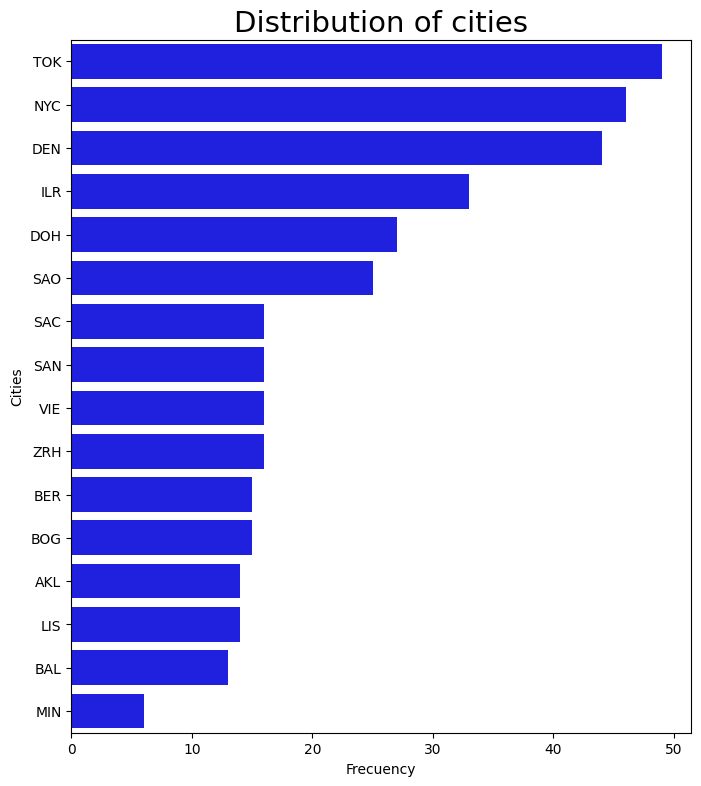

In [55]:
fig, ax = plt.subplots(1,1 ,figsize=(8, 9))
sns.countplot(data=otus_df, y="ID_city", order=otus_df.ID_city.value_counts().index, color="blue")
plt.xlabel("Frecuency")
plt.ylabel("Cities")
plt.title("Distribution of cities", fontsize=21)
plt.show()

In [ ]:
#y_counts = otus_df.ID_city.value_counts()
#y_counts

In [56]:
from sklearn.preprocessing import LabelEncoder
from camda_functions import split_stratified_into_train_val_test

In [57]:
#X = np.array(otus_df.drop(y_names,axis=1)).astype('float')
X = otus_df.drop(y_names,axis=1).astype('float')
y = np.array(otus_df[y_names]).ravel()
# categorización de la respuesta
le = LabelEncoder()
le.fit(y)
#le.classes_
y_cat = le.transform(y)
#le.inverse_transform(y_cat[:5])

# create train (70%), validation (20%) and test (10%) datasets
X_train, y_train, X_val, y_val, X_test, y_test, class_w, __ = \
    split_stratified_into_train_val_test(X, y_cat, .70, .10, .20, std=True, two_subsets=True)

In [58]:
X_train.shape

(291, 287)

### Random forests (baseline)

In [10]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

n_trees = 1000
rf = RandomForestClassifier(n_estimators=n_trees, min_samples_split=3, oob_score=True, n_jobs=-1, random_state=42)
rf.fit(X_train,y_train)
# predecir datos de validacion
y_test_hat = rf.predict(X_test)

print(metrics.classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.00      0.00      0.00         3
           2       0.60      1.00      0.75         3
           3       0.00      0.00      0.00         3
           4       0.53      0.89      0.67         9
           5       0.50      0.50      0.50         6
           6       0.67      0.57      0.62         7
           7       0.50      0.67      0.57         3
           8       0.00      0.00      0.00         1
           9       0.47      1.00      0.64         9
          10       1.00      1.00      1.00         3
          11       0.50      0.33      0.40         3
          12       0.67      0.40      0.50         5
          13       0.89      0.80      0.84        10
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         3

    accuracy                           0.59        74
   macro avg       0.46   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


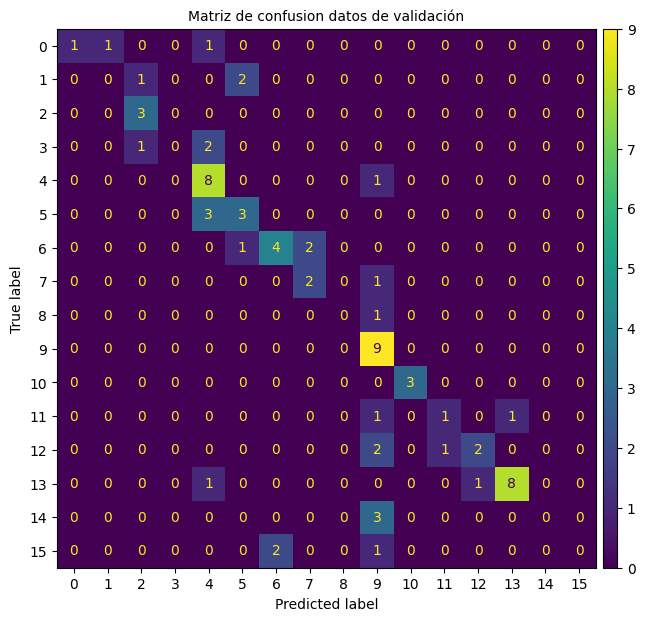

In [11]:
plt.style.use('default') 
cm = metrics.confusion_matrix(y_test, y_test_hat, normalize=None)
disp1 = metrics.ConfusionMatrixDisplay(cm, display_labels=np.arange(len(le.classes_)))
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Matriz de confusion datos de validación',{'fontsize':10})

disp1.plot(ax=ax, colorbar=False)
# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(disp1.im_,  cax=cax);

### Neural network

In [59]:
# create train (70%), validation (20%) and test (10%) datasets
X_tr, y_tr, X_val, y_val, X_te, y_te, class_w, __ = split_stratified_into_train_val_test(X, y_cat, .70, .20, .10)

In [61]:
tt = pd.DataFrame({'counts':np.bincount(y_cat),'class_weight':class_w},index=le.inverse_transform(np.unique(y_tr)))
tt.sort_values('counts')

,counts,class_weight
MIN,6,4.100000
BAL,13,1.708333
AKL,14,1.576923
LIS,14,1.576923
BER,15,1.464286
BOG,15,1.464286
SAC,16,1.464286
SAN,16,1.464286
VIE,16,1.464286
ZRH,16,1.464286


In [62]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [63]:
# Turn data into tensors
X_train = torch.from_numpy(X_tr).type(torch.float)
y_train = torch.from_numpy(y_tr).type(torch.LongTensor)
X_val = torch.from_numpy(X_val).type(torch.float)
y_val = torch.from_numpy(y_val).type(torch.LongTensor)
X_test = torch.from_numpy(X_te).type(torch.float)
y_test = torch.from_numpy(y_te).type(torch.LongTensor)
class_weights = torch.tensor(class_w,dtype=torch.float)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
class_weights = class_weights.to(device)

In [64]:
X_train.shape

torch.Size([255, 287])

In [86]:
class nnet_otus(nn.Module):
    def __init__(self, input_features, output_features):
        super(nnet_otus, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=520), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=520, out_features=520), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=520, out_features=300), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=300, out_features=100), 
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=output_features), 
        )

    def forward(self, x):
        return self.seq(x)


class nnet_otus(nn.Module):
    def __init__(self, input_features, output_features):
        super(nnet_otus, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=300), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=300, out_features=300), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=300, out_features=250), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=250, out_features=100), 
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=output_features), 
        )
    def forward(self, x):
        return self.seq(x)

In [101]:
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

batch_size_val = 16
batch_size_tr = 32
# Builds a loader for each dataset to perform mini-batch gradient descent
train_loader = DataLoader(dataset=train_data, batch_size=batch_size_tr, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size_val, shuffle=False)

In [102]:
# Set the hyperparameters for data creation
NUM_CLASSES = len(le.classes_)
NUM_FEATURES = X_train.shape[1]

# Create an instance of the model and send it to target device
model = nnet_otus(NUM_FEATURES, NUM_CLASSES).to(device)

# Setup loss and optimizer 
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-5) 

# Fit the model
torch.manual_seed(42)
epochs = 200
# Build training and evaluation loop
for epoch in range(epochs):  
    ### Training
    model.train()
    for x_batch, y_batch in train_loader:
      
      # 1. Forward pass (model outputs raw logits)
      y_logits = model(x_batch) # model outputs raw logits 
      y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

      # 2. Calculate loss/accuracy
      loss = loss_fn(y_logits, y_batch) 
      acc = accuracy_score(y_batch.detach().cpu().numpy(), y_pred.detach().cpu().numpy()) 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # Uses loader to fetch one mini-batch for validation
      for x_batch, y_batch in val_loader:
          # 1. Forward pass
          test_logits = model(x_batch)
          test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
          # 2. Caculate loss/accuracy
          test_loss = loss_fn(test_logits, y_batch)
          test_acc = accuracy_score(y_batch.detach().cpu().numpy(), test_pred.detach().cpu().numpy())

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation loss: {test_loss:.5f}, Validation acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 2.77284, Accuracy: 0.10% | Validation loss: 2.79285, Validation acc: 0.11%
Epoch: 10 | Loss: 2.73651, Accuracy: 0.06% | Validation loss: 2.74359, Validation acc: 0.11%
Epoch: 20 | Loss: 2.31906, Accuracy: 0.32% | Validation loss: 2.42004, Validation acc: 0.22%
Epoch: 30 | Loss: 1.35050, Accuracy: 0.55% | Validation loss: 2.15414, Validation acc: 0.22%
Epoch: 40 | Loss: 0.55606, Accuracy: 0.74% | Validation loss: 2.87227, Validation acc: 0.22%
Epoch: 50 | Loss: 0.19566, Accuracy: 0.97% | Validation loss: 4.10618, Validation acc: 0.22%
Epoch: 60 | Loss: 0.35358, Accuracy: 0.94% | Validation loss: 2.81035, Validation acc: 0.67%
Epoch: 70 | Loss: 0.13298, Accuracy: 0.94% | Validation loss: 3.92491, Validation acc: 0.44%
Epoch: 80 | Loss: 0.04363, Accuracy: 1.00% | Validation loss: 3.94767, Validation acc: 0.44%
Epoch: 90 | Loss: 0.02852, Accuracy: 1.00% | Validation loss: 4.10547, Validation acc: 0.56%
Epoch: 100 | Loss: 1.78577, Accuracy: 0.90% | Validation loss: 6.43832,

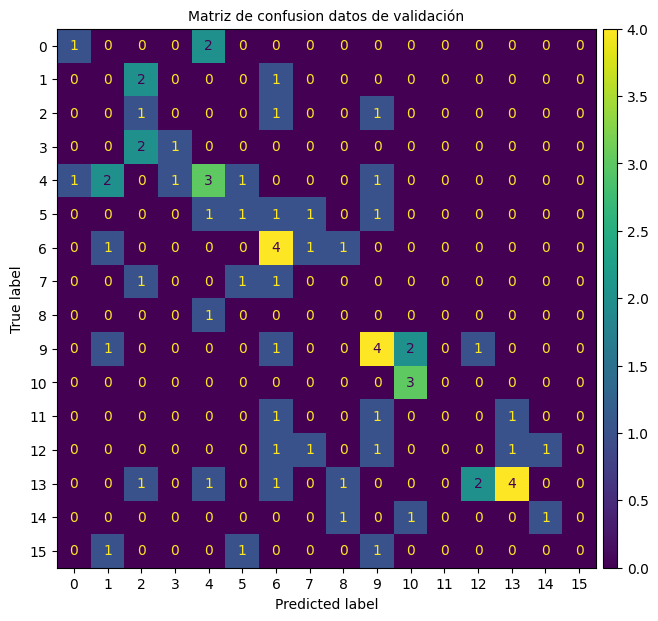

In [103]:
model.eval()
with torch.no_grad():
  val_logits = model(X_val)
  y_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)

plt.style.use('default') 
cm = metrics.confusion_matrix(y_val.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), normalize=None)
disp1 = metrics.ConfusionMatrixDisplay(cm, display_labels=np.arange(len(le.classes_)))
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Matriz de confusion datos de validación',{'fontsize':10})

disp1.plot(ax=ax, colorbar=False)
# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(disp1.im_,  cax=cax);

In [104]:
print(metrics.classification_report(y_val.detach().cpu().numpy(), y_pred.detach().cpu().numpy()))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.00      0.00      0.00         3
           2       0.14      0.33      0.20         3
           3       0.50      0.33      0.40         3
           4       0.38      0.33      0.35         9
           5       0.25      0.20      0.22         5
           6       0.33      0.57      0.42         7
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         1
           9       0.40      0.44      0.42         9
          10       0.50      1.00      0.67         3
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         5
          13       0.67      0.40      0.50        10
          14       0.50      0.33      0.40         3
          15       0.00      0.00      0.00         3

    accuracy                           0.32        73
   macro avg       0.26   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


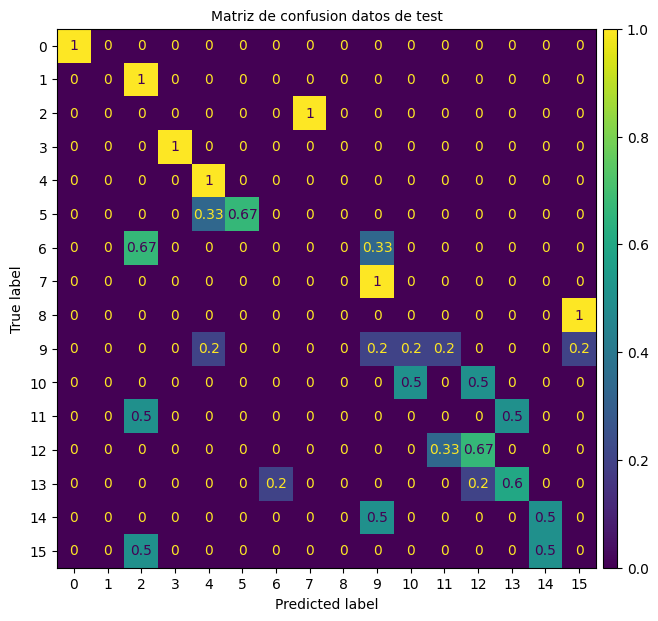

In [105]:
model.eval()
with torch.no_grad():
  val_logits = model(X_test)
  y_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)

plt.style.use('default') 
cm = metrics.confusion_matrix(y_test.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), normalize='true')
disp1 = metrics.ConfusionMatrixDisplay(cm, display_labels=np.arange(len(le.classes_)))
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Matriz de confusion datos de test',{'fontsize':10})

disp1.plot(ax=ax, colorbar=False)
# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(disp1.im_,  cax=cax);

In [106]:
print(metrics.classification_report(y_test.detach().cpu().numpy(), y_pred.detach().cpu().numpy()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       0.67      1.00      0.80         4
           5       1.00      0.67      0.80         3
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.25      0.20      0.22         5
          10       0.50      0.50      0.50         2
          11       0.00      0.00      0.00         2
          12       0.50      0.67      0.57         3
          13       0.75      0.60      0.67         5
          14       0.50      0.50      0.50         2
          15       0.00      0.00      0.00         2

    accuracy                           0.43        37
   macro avg       0.39   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## $X$: Genes, $y$: city

In [144]:
carpeta_data = "data"
nombre_archivo = "amr-counts_card_info_20230604.tsv"
# Obtén la ruta absoluta de la carpeta actual
ruta_actual = os.getcwd()
# Construye la ruta completa al archivo CSV dentro de la carpeta "data"
ruta_archivo = os.path.join(ruta_actual, carpeta_data, nombre_archivo)
temp_data = pd.read_table(ruta_archivo, delimiter="\t")
names_to_drop = ["name","ARO","ARO_Trace","Aro_name_trace","family", "drugClass","mechanism"]
genes_data = pd.DataFrame(temp_data.drop(names_to_drop, axis=1).transpose())
genes_data.columns = temp_data['ARO']
#genes_data

In [108]:
from camda_functions import get_tfidf, load_from_pickle

In [110]:
# cargar un modelo de factorización de matrices sparse ya entrenado
f_path = os.path.join(ruta_actual, carpeta_data)
pkl_file = 'nmf.pkl'
nmf_model = load_from_pickle(f_path, pkl_file)

tfidf = get_tfidf(genes_data)
lsa_genes = nmf_model.transform(tfidf)
lsa_genes.shape

(365, 150)

In [111]:
lsa_genes

array([[2.82498365e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.50072344e-03, 1.39766199e-01, 2.42880283e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.26342275e-02, 2.77424188e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.66192525e-02, 0.00000000e+00, 4.37743329e-04, ...,
        0.00000000e+00, 9.00517414e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.74527994e-03, 0.00000000e+00, 0.00000000e+00],
       [2.72233763e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [112]:
latent_names = [f"t {i}" for i in range(lsa_genes.shape[1])]
otus_y = otus["ID_city"]
lsa_df = pd.DataFrame(lsa_genes, index=genes_data.index, columns=latent_names)
# junto las tablas de genes y otus, solo para estar seguro de que tienen las mismas observaciones
lsa_city = lsa_df.join(otus_y, how="inner")

In [113]:
#X = np.array(otus_df.drop(y_names,axis=1)).astype('float')
X = lsa_city.drop("ID_city",axis=1).astype('float')
y = np.array(lsa_city[y_names]).ravel()
# categorización de la respuesta
le = LabelEncoder()
le.fit(y)
#le.classes_
y_cat = le.transform(y)
#le.inverse_transform(y_cat[:5])

# create train (70%), validation (20%) and test (10%) datasets
X_train, y_train, X_val, y_val, X_test, y_test, class_w, __ = \
    split_stratified_into_train_val_test(X, y_cat, .70, .10, .20, std=False, two_subsets=True)

In [145]:
type(X)

pandas.core.frame.DataFrame

### Random forests (baseline)

In [20]:
n_trees = 800
rf = RandomForestClassifier(n_estimators=n_trees, min_samples_split=3, oob_score=True, n_jobs=-1, random_state=42)
rf.fit(X_train,y_train)
# predecir datos de validacion
y_test_hat = rf.predict(X_test)

print(metrics.classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         3
           3       1.00      0.67      0.80         3
           4       0.46      0.67      0.55         9
           5       0.20      0.17      0.18         6
           6       0.50      0.57      0.53         7
           7       1.00      0.67      0.80         3
           8       0.00      0.00      0.00         1
           9       0.44      0.78      0.56         9
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         3
          12       0.14      0.20      0.17         5
          13       0.50      0.90      0.64        10
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         3

    accuracy                           0.43        74
   macro avg       0.27   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


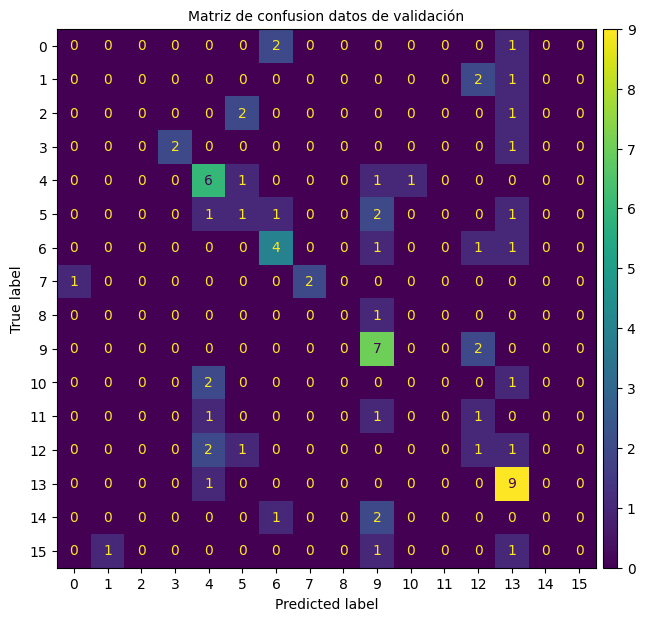

In [21]:
plt.style.use('default') 
cm = metrics.confusion_matrix(y_test, y_test_hat, normalize=None)
disp1 = metrics.ConfusionMatrixDisplay(cm, display_labels=np.arange(len(le.classes_)))
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Matriz de confusion datos de validación',{'fontsize':10})

disp1.plot(ax=ax, colorbar=False)
# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(disp1.im_,  cax=cax);

### Neural network

In [163]:
X = np.array(otus_df.drop(y_names,axis=1)).astype('float')
#X = lsa_city.drop("ID_city",axis=1).astype('float')
y = np.array(lsa_city[y_names]).ravel()
# categorización de la respuesta
le = LabelEncoder()
le.fit(y)
#le.classes_
y_cat = le.transform(y)
#le.inverse_transform(y_cat[:5])

In [164]:
# create train (70%), validation (20%) and test (10%) datasets
X_tr, y_tr, X_val, y_val, X_te, y_te, class_w, __ = split_stratified_into_train_val_test(X, y_cat, .70, .20, .10, std=True, two_subsets=False)

In [165]:
tt = pd.DataFrame({'counts':np.bincount(y_cat),'class_weight':class_w},index=le.inverse_transform(np.unique(y_tr)))
tt.sort_values('counts')

,counts,class_weight
MIN,6,4.100000
BAL,13,1.708333
AKL,14,1.576923
LIS,14,1.576923
BER,15,1.464286
BOG,15,1.464286
SAC,16,1.464286
SAN,16,1.464286
VIE,16,1.464286
ZRH,16,1.464286


In [166]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [167]:
# Turn data into tensors
X_train = torch.from_numpy(X_tr).type(torch.float)
y_train = torch.from_numpy(y_tr).type(torch.LongTensor)
X_val = torch.from_numpy(X_val).type(torch.float)
y_val = torch.from_numpy(y_val).type(torch.LongTensor)
X_test = torch.from_numpy(X_te).type(torch.float)
y_test = torch.from_numpy(y_te).type(torch.LongTensor)
class_weights = torch.tensor(class_w,dtype=torch.float)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
class_weights = class_weights.to(device)

In [168]:
X_train.shape

torch.Size([255, 287])

In [169]:
class nnet_otus(nn.Module):
    def __init__(self, input_features, output_features):
        super(nnet_otus, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=520), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=520, out_features=520), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=520, out_features=300), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=300, out_features=100), 
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=output_features), 
        )

    def forward(self, x):
        return self.seq(x)


class nnet_otus(nn.Module):
    def __init__(self, input_features, output_features):
        super(nnet_otus, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=300), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=300, out_features=300), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=300, out_features=250), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=250, out_features=100), 
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=output_features), 
        )
    def forward(self, x):
        return self.seq(x)

In [170]:
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

batch_size_val = 16
batch_size_tr = 32
# Builds a loader for each dataset to perform mini-batch gradient descent
train_loader = DataLoader(dataset=train_data, batch_size=batch_size_tr, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size_val, shuffle=False)

In [171]:
# Set the hyperparameters for data creation
NUM_CLASSES = len(le.classes_)
NUM_FEATURES = X_train.shape[1]

# Create an instance of the model and send it to target device
model = nnet_otus(NUM_FEATURES, NUM_CLASSES).to(device)

# Setup loss and optimizer 
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-5) 

# Fit the model
torch.manual_seed(42)
epochs = 500
# Build training and evaluation loop
for epoch in range(epochs):  
    ### Training
    model.train()
    for x_batch, y_batch in train_loader:
      
      # 1. Forward pass (model outputs raw logits)
      y_logits = model(x_batch) # model outputs raw logits 
      y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

      # 2. Calculate loss/accuracy
      loss = loss_fn(y_logits, y_batch) 
      acc = accuracy_score(y_batch.detach().cpu().numpy(), y_pred.detach().cpu().numpy()) 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # Uses loader to fetch one mini-batch for validation
      for x_batch, y_batch in val_loader:
          # 1. Forward pass
          test_logits = model(x_batch)
          test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
          # 2. Caculate loss/accuracy
          test_loss = loss_fn(test_logits, y_batch)
          test_acc = accuracy_score(y_batch.detach().cpu().numpy(), test_pred.detach().cpu().numpy())

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation loss: {test_loss:.5f}, Validation acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 2.79731, Accuracy: 0.00% | Validation loss: 2.78280, Validation acc: 0.00%
Epoch: 10 | Loss: 2.75579, Accuracy: 0.03% | Validation loss: 2.78578, Validation acc: 0.11%
Epoch: 20 | Loss: 2.29842, Accuracy: 0.42% | Validation loss: 2.68006, Validation acc: 0.22%
Epoch: 30 | Loss: 1.00165, Accuracy: 0.61% | Validation loss: 3.09410, Validation acc: 0.11%
Epoch: 40 | Loss: 0.39559, Accuracy: 0.90% | Validation loss: 4.12215, Validation acc: 0.22%
Epoch: 50 | Loss: 0.11350, Accuracy: 0.97% | Validation loss: 6.00680, Validation acc: 0.44%
Epoch: 60 | Loss: 0.12410, Accuracy: 0.97% | Validation loss: 6.94338, Validation acc: 0.44%
Epoch: 70 | Loss: 0.03900, Accuracy: 1.00% | Validation loss: 7.12222, Validation acc: 0.56%
Epoch: 80 | Loss: 0.11941, Accuracy: 0.97% | Validation loss: 7.48297, Validation acc: 0.44%
Epoch: 90 | Loss: 0.03331, Accuracy: 1.00% | Validation loss: 7.10560, Validation acc: 0.44%
Epoch: 100 | Loss: 0.03305, Accuracy: 0.97% | Validation loss: 7.27617,

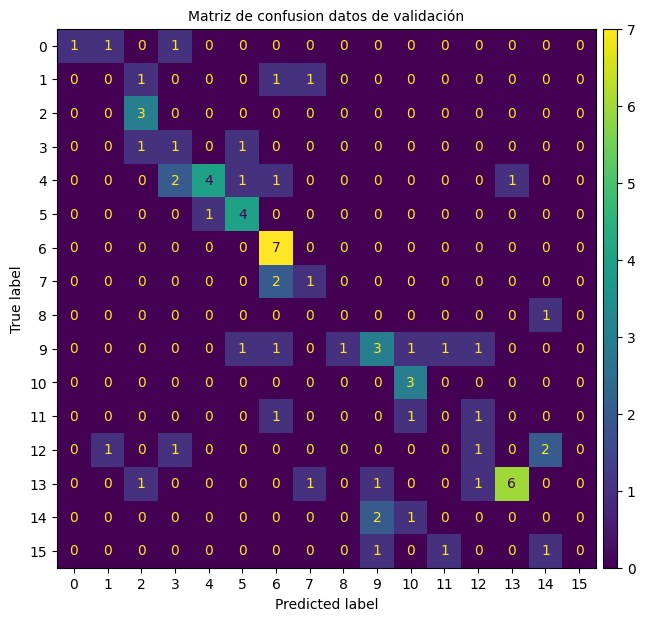

In [172]:
model.eval()
with torch.no_grad():
  val_logits = model(X_val)
  y_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)

plt.style.use('default') 
cm = metrics.confusion_matrix(y_val.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), normalize=None)
disp1 = metrics.ConfusionMatrixDisplay(cm, display_labels=np.arange(len(le.classes_)))
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Matriz de confusion datos de validación',{'fontsize':10})

disp1.plot(ax=ax, colorbar=False)
# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(disp1.im_,  cax=cax);

In [173]:
print(metrics.classification_report(y_val.detach().cpu().numpy(), y_pred.detach().cpu().numpy()))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.00      0.00      0.00         3
           2       0.50      1.00      0.67         3
           3       0.20      0.33      0.25         3
           4       0.80      0.44      0.57         9
           5       0.57      0.80      0.67         5
           6       0.54      1.00      0.70         7
           7       0.33      0.33      0.33         3
           8       0.00      0.00      0.00         1
           9       0.43      0.33      0.38         9
          10       0.50      1.00      0.67         3
          11       0.00      0.00      0.00         3
          12       0.25      0.20      0.22         5
          13       0.86      0.60      0.71        10
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         3

    accuracy                           0.47        73
   macro avg       0.37   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


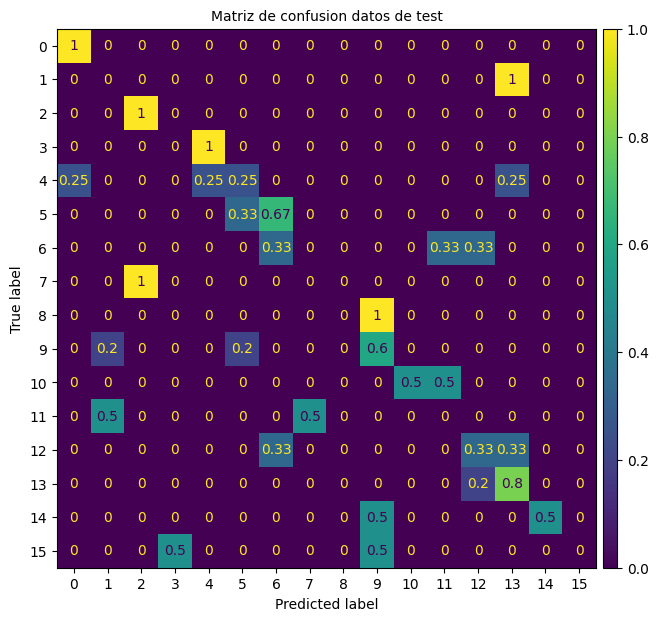

In [174]:
model.eval()
with torch.no_grad():
  val_logits = model(X_test)
  y_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)

plt.style.use('default') 
cm = metrics.confusion_matrix(y_test.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), normalize='true')
disp1 = metrics.ConfusionMatrixDisplay(cm, display_labels=np.arange(len(le.classes_)))
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Matriz de confusion datos de test',{'fontsize':10})

disp1.plot(ax=ax, colorbar=False)
# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(disp1.im_,  cax=cax);

In [175]:
print(metrics.classification_report(y_test.detach().cpu().numpy(), y_pred.detach().cpu().numpy()))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         1
           4       0.50      0.25      0.33         4
           5       0.33      0.33      0.33         3
           6       0.25      0.33      0.29         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.50      0.60      0.55         5
          10       1.00      0.50      0.67         2
          11       0.00      0.00      0.00         2
          12       0.33      0.33      0.33         3
          13       0.57      0.80      0.67         5
          14       1.00      0.50      0.67         2
          15       0.00      0.00      0.00         2

    accuracy                           0.41        37
   macro avg       0.34   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## $X$: OTUS + Genes, $y$: city

In [4]:
carpeta_data = "data"
nombre_archivo = "amr-counts_card_info_20230604.tsv"
# Obtén la ruta absoluta de la carpeta actual
ruta_actual = os.getcwd()
# Construye la ruta completa al archivo CSV dentro de la carpeta "data"
ruta_archivo = os.path.join(ruta_actual, carpeta_data, nombre_archivo)
temp_data = pd.read_table(ruta_archivo, delimiter="\t")
names_to_drop = ["name","ARO","ARO_Trace","Aro_name_trace","family", "drugClass","mechanism"]
genes_data = pd.DataFrame(temp_data.drop(names_to_drop, axis=1).transpose())
genes_data.columns = temp_data['ARO']
#genes_data

In [8]:
carpeta_data = "data"
nombre_archivo = "relative_order_assembly.csv"

# Obtén la ruta absoluta de la carpeta actual
ruta_actual = os.getcwd()
# Construye la ruta completa al archivo CSV dentro de la carpeta "data"
ruta_archivo = os.path.join(ruta_actual, carpeta_data, nombre_archivo)
otus = pd.read_csv(ruta_archivo, index_col="ID")

cont_names = list(otus.drop(["ID_city","City","Climate","Latitude", "Longitude","Year"], axis=1).columns)
y_names = ["ID_city"]
otus_df = otus[cont_names+y_names]
otus_df.shape

(365, 288)

In [5]:
from camda_functions import get_tfidf, load_from_pickle

# cargar un modelo de factorización de matrices sparse ya entrenado
f_path = os.path.join(ruta_actual, carpeta_data)
pkl_file = 'nmf.pkl'
nmf_model = load_from_pickle(f_path, pkl_file)

tfidf = get_tfidf(genes_data)
lsa_genes = nmf_model.transform(tfidf)
lsa_genes.shape

(365, 150)

In [9]:
X2 = otus_df.drop(y_names,axis=1).astype('float')
latent_names = [f"t {i}" for i in range(lsa_genes.shape[1])]
otus_y = otus["ID_city"]
lsa_df = pd.DataFrame(lsa_genes, index=genes_data.index, columns=latent_names)
# junto las tablas de genes y otus
genes_otus = lsa_df.join(X2, how="inner")
genes_otus = genes_otus.join(otus_y, how="inner")
genes_otus

,t 0,t 1,t 2,t 3,t 4,t 5,t 6,t 7,t 8,t 9,...,X2170046,X675060,X1655646,X10660,X2956583,X2746926,X2169857,X2956349,X2025397,ID_city
CAMDA23_MetaSUB_gCSD16_AKL_1,0.002825,0.000000,0.000000,0.000000,0.000000,0.000000,0.271512,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AKL
CAMDA23_MetaSUB_gCSD16_AKL_10,0.008501,0.139766,0.000243,0.071551,0.002660,0.002425,0.113093,0.002001,0.00000,0.001566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AKL
CAMDA23_MetaSUB_gCSD16_AKL_11,0.082634,0.277424,0.000000,0.003612,0.000000,0.000128,0.000000,0.000000,0.00031,0.000008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AKL
CAMDA23_MetaSUB_gCSD16_AKL_12,0.000000,0.001469,0.117031,0.000000,0.202132,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AKL
CAMDA23_MetaSUB_gCSD16_AKL_13,0.066484,0.000000,0.000000,0.000000,0.008551,0.000000,0.000000,0.000446,0.00000,0.000494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AKL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAMDA23_MetaSUB_gCSD17_ZRH_5,0.011935,0.007830,0.000786,0.000000,0.000000,0.000000,0.012627,0.000000,0.00000,0.010112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZRH
CAMDA23_MetaSUB_gCSD17_ZRH_6,0.095482,0.000000,0.000119,0.000000,0.000000,0.000000,0.000112,0.000000,0.00000,0.013616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZRH
CAMDA23_MetaSUB_gCSD17_ZRH_7,0.096619,0.000000,0.000438,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.002512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZRH
CAMDA23_MetaSUB_gCSD17_ZRH_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.002130,0.000000,0.000000,0.00000,0.006866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZRH


In [13]:
from sklearn.preprocessing import LabelEncoder
from camda_functions import split_stratified_into_train_val_test
from sklearn import metrics
from sklearn.metrics import accuracy_score

#X = np.array(otus_df.drop(y_names,axis=1)).astype('float')
X = genes_otus.drop("ID_city",axis=1).astype('float')
y = np.array(genes_otus[y_names]).ravel()
# categorización de la respuesta
le = LabelEncoder()
le.fit(y)
#le.classes_
y_cat = le.transform(y)
#le.inverse_transform(y_cat[:5])

In [14]:
# create train (70%), validation (20%) and test (10%) datasets
X_tr, y_tr, X_val, y_val, X_te, y_te, class_w, __ = split_stratified_into_train_val_test(X, y_cat, .70, .20, .10, std=True, two_subsets=False)

In [15]:
tt = pd.DataFrame({'counts':np.bincount(y_cat),'class_weight':class_w},index=le.inverse_transform(np.unique(y_tr)))
tt.sort_values('counts')

,counts,class_weight
MIN,6,4.100000
BAL,13,1.708333
AKL,14,1.576923
LIS,14,1.576923
BER,15,1.464286
BOG,15,1.464286
SAC,16,1.464286
SAN,16,1.464286
VIE,16,1.464286
ZRH,16,1.464286


In [16]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
# Turn data into tensors
X_train = torch.from_numpy(X_tr).type(torch.float)
y_train = torch.from_numpy(y_tr).type(torch.LongTensor)
X_val = torch.from_numpy(X_val).type(torch.float)
y_val = torch.from_numpy(y_val).type(torch.LongTensor)
X_test = torch.from_numpy(X_te).type(torch.float)
y_test = torch.from_numpy(y_te).type(torch.LongTensor)
class_weights = torch.tensor(class_w,dtype=torch.float)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
class_weights = class_weights.to(device)

In [18]:
X_train.shape

torch.Size([255, 437])

In [33]:
class nnet_otus(nn.Module):
    def __init__(self, input_features, output_features):
        super(nnet_otus, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=1200), 
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=1200, out_features=520), 
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=520, out_features=300), 
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=300, out_features=300), 
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=300, out_features=100), 
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=output_features), 
        )

    def forward(self, x):
        return self.seq(x)


In [34]:
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

batch_size_val = 16
batch_size_tr = 32
# Builds a loader for each dataset to perform mini-batch gradient descent
train_loader = DataLoader(dataset=train_data, batch_size=batch_size_tr, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size_val, shuffle=False)

In [35]:
# Set the hyperparameters for data creation
NUM_CLASSES = len(le.classes_)
NUM_FEATURES = X_train.shape[1]

# Create an instance of the model and send it to target device
model = nnet_otus(NUM_FEATURES, NUM_CLASSES).to(device)

# Setup loss and optimizer 
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-5) 

# Fit the model
torch.manual_seed(42)
epochs = 200
# Build training and evaluation loop
for epoch in range(epochs):  
    ### Training
    model.train()
    for x_batch, y_batch in train_loader:
      
      # 1. Forward pass (model outputs raw logits)
      y_logits = model(x_batch) # model outputs raw logits 
      y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

      # 2. Calculate loss/accuracy
      loss = loss_fn(y_logits, y_batch) 
      acc = accuracy_score(y_batch.detach().cpu().numpy(), y_pred.detach().cpu().numpy()) 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # Uses loader to fetch one mini-batch for validation
      for x_batch, y_batch in val_loader:
          # 1. Forward pass
          test_logits = model(x_batch)
          test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
          # 2. Caculate loss/accuracy
          test_loss = loss_fn(test_logits, y_batch)
          test_acc = accuracy_score(y_batch.detach().cpu().numpy(), test_pred.detach().cpu().numpy())

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation loss: {test_loss:.5f}, Validation acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 2.79847, Accuracy: 0.00% | Validation loss: 2.78477, Validation acc: 0.00%
Epoch: 10 | Loss: 2.78231, Accuracy: 0.00% | Validation loss: 2.77632, Validation acc: 0.11%
Epoch: 20 | Loss: 2.75591, Accuracy: 0.06% | Validation loss: 2.77543, Validation acc: 0.00%
Epoch: 30 | Loss: 2.67576, Accuracy: 0.06% | Validation loss: 2.74663, Validation acc: 0.11%
Epoch: 40 | Loss: 2.48128, Accuracy: 0.13% | Validation loss: 2.62159, Validation acc: 0.33%
Epoch: 50 | Loss: 2.02150, Accuracy: 0.35% | Validation loss: 2.53356, Validation acc: 0.33%
Epoch: 60 | Loss: 1.09832, Accuracy: 0.61% | Validation loss: 2.13059, Validation acc: 0.33%
Epoch: 70 | Loss: 0.91969, Accuracy: 0.81% | Validation loss: 2.60972, Validation acc: 0.33%
Epoch: 80 | Loss: 0.12436, Accuracy: 0.97% | Validation loss: 1.95488, Validation acc: 0.67%
Epoch: 90 | Loss: 0.04757, Accuracy: 1.00% | Validation loss: 1.61002, Validation acc: 0.67%
Epoch: 100 | Loss: 0.28964, Accuracy: 0.94% | Validation loss: 2.61929,

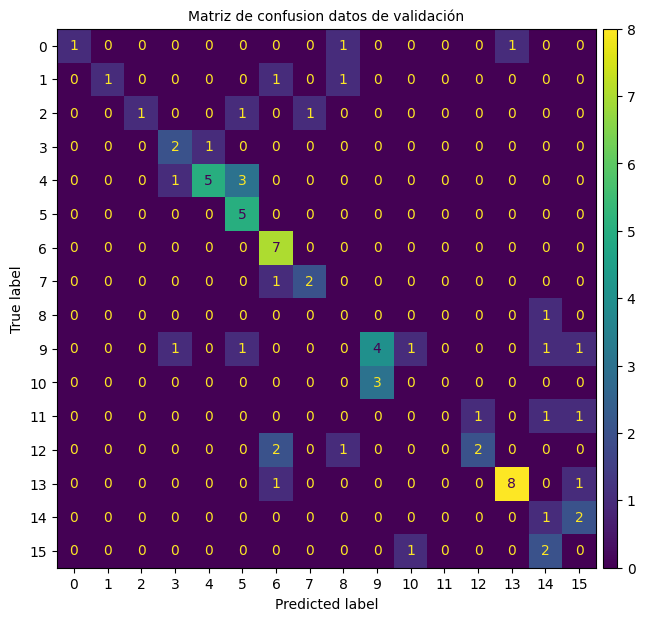

In [36]:
model.eval()
with torch.no_grad():
  val_logits = model(X_val)
  y_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)

plt.style.use('default') 
cm = metrics.confusion_matrix(y_val.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), normalize=None)
disp1 = metrics.ConfusionMatrixDisplay(cm, display_labels=np.arange(len(le.classes_)))
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Matriz de confusion datos de validación',{'fontsize':10})

disp1.plot(ax=ax, colorbar=False)
# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(disp1.im_,  cax=cax);

In [37]:
print(metrics.classification_report(y_val.detach().cpu().numpy(), y_pred.detach().cpu().numpy()))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      0.33      0.50         3
           2       1.00      0.33      0.50         3
           3       0.50      0.67      0.57         3
           4       0.83      0.56      0.67         9
           5       0.50      1.00      0.67         5
           6       0.58      1.00      0.74         7
           7       0.67      0.67      0.67         3
           8       0.00      0.00      0.00         1
           9       0.57      0.44      0.50         9
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         3
          12       0.67      0.40      0.50         5
          13       0.89      0.80      0.84        10
          14       0.17      0.33      0.22         3
          15       0.00      0.00      0.00         3

    accuracy                           0.53        73
   macro avg       0.52   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


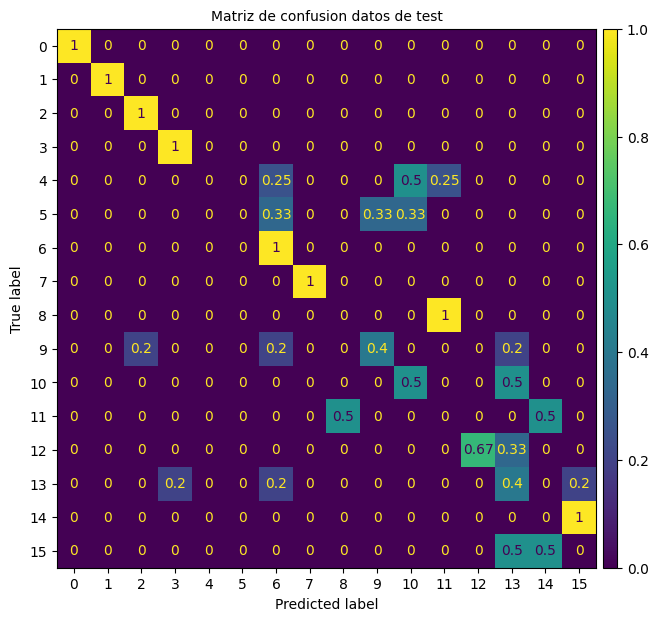

In [38]:
model.eval()
with torch.no_grad():
  val_logits = model(X_test)
  y_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)

plt.style.use('default') 
cm = metrics.confusion_matrix(y_test.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), normalize='true')
disp1 = metrics.ConfusionMatrixDisplay(cm, display_labels=np.arange(len(le.classes_)))
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Matriz de confusion datos de test',{'fontsize':10})

disp1.plot(ax=ax, colorbar=False)
# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(disp1.im_,  cax=cax);

In [27]:
print(metrics.classification_report(y_test.detach().cpu().numpy(), y_pred.detach().cpu().numpy()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.50      1.00      0.67         1
           2       0.50      1.00      0.67         1
           3       1.00      1.00      1.00         1
           4       0.33      0.25      0.29         4
           5       0.50      0.33      0.40         3
           6       0.50      0.33      0.40         3
           7       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         1
           9       0.29      0.40      0.33         5
          10       0.33      0.50      0.40         2
          11       0.00      0.00      0.00         2
          12       1.00      0.33      0.50         3
          13       0.60      0.60      0.60         5
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         2

    accuracy                           0.41        37
   macro avg       0.47   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
